In [1]:
import pandas as pd
import pickle
import random
from surprise import prediction_algorithms as pa
from surprise import Dataset, Reader, GridSearch, accuracy, dump
from surprise import evaluate, print_perf
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./ml-100k/data.csv')
df = pd.DataFrame(data)
df.drop('timestamp', axis=1, inplace=True)
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
raw_ratings = dataset.raw_ratings
random.shuffle(raw_ratings)
threshold = int(.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]
dataset.raw_ratings = A_raw_ratings
dataset.split(n_folds=5)

In [3]:
res = {}
res['nmf'] = {}
res['svd'] = {}

latent_factors = [10,20,30,40,50,60,70,80,90,100]
for lf in latent_factors:
    
    start_time = int(time.time())
    trainset = dataset.build_full_trainset()
    algo = pa.matrix_factorization.NMF(n_factors=lf, n_epochs=100, biased=True, reg_pu=0.05, reg_qi=0.05, reg_bu=0.05, reg_bi=0.05, lr_bu=0.001, lr_bi=0.001)
    algo.train(trainset)
    end_time = int(time.time())
    print (start_time-end_time)
    testset = dataset.construct_testset(B_raw_ratings)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    res['nmf'][lf] = (rmse,mae)
    
    start_time = int(time.time())
    trainset = dataset.build_full_trainset()
    algo = pa.matrix_factorization.SVD(n_factors=lf, n_epochs=20, reg_all=0.05, lr_all=0.005)
    algo.train(trainset)
    end_time = int(time.time())
    print (start_time-end_time)
    testset = dataset.construct_testset(B_raw_ratings)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    res['svd'][lf] = (rmse,mae)

pickle.dump(res,open('./nmf_svd_factor_plot.dat','wb'))

-6
RMSE: 0.9336
MAE:  0.7354
-1
RMSE: 0.9411
MAE:  0.7450
-7
RMSE: 0.9315
MAE:  0.7347
-1
RMSE: 0.9374
MAE:  0.7418
-9
RMSE: 1.2909
MAE:  0.9846
-2
RMSE: 0.9380
MAE:  0.7417
-11
RMSE: 1.9660
MAE:  1.6096
-2
RMSE: 0.9361
MAE:  0.7402
-12
RMSE: 1.2853
MAE:  0.9873
-2
RMSE: 0.9346
MAE:  0.7391
-15
RMSE: 2.2251
MAE:  1.8606
-3
RMSE: 0.9350
MAE:  0.7393
-15
RMSE: 1.2918
MAE:  0.9800
-2
RMSE: 0.9342
MAE:  0.7395
-16
RMSE: 1.5867
MAE:  1.2432
-3
RMSE: 0.9348
MAE:  0.7394
-18
RMSE: 1.3140
MAE:  0.9990
-3
RMSE: 0.9323
MAE:  0.7368
-25
RMSE: 1.4726
MAE:  1.1308
-3
RMSE: 0.9327
MAE:  0.7376


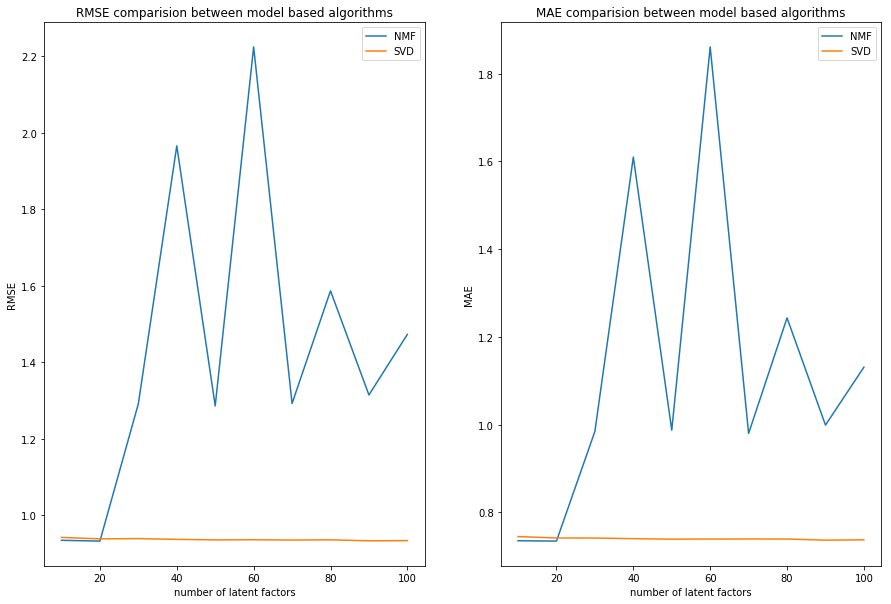

In [6]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
subplots = [ax1, ax2]
error_metric = ["RMSE","MAE"]
algorithms = ["NMF","SVD"]
latent_factors = [10,20,30,40,50,60,70,80,90,100]
data = {}
data[0] = {}
data[0]["NMF"] = [res['nmf'][x][0] for x in latent_factors]
data[0]["SVD"] = [res['svd'][x][0] for x in latent_factors]
data[1] = {}
data[1]["NMF"] = [res['nmf'][x][1] for x in latent_factors]
data[1]["SVD"] = [res['svd'][x][1] for x in latent_factors]

for i in range(len(subplots)):
    for algorithm in algorithms:
        subplots[i].plot(latent_factors, data[i][algorithm], label=algorithm)
        subplots[i].set_xlabel("number of latent factors")
        subplots[i].set_ylabel(error_metric[i])
        subplots[i].set_title(error_metric[i]+" comparision between model based algorithms")
        subplots[i].legend(loc="upper right")
plt.show()
fig.savefig('./nmf_svd_comparision.png')